Words that occur nearby frequently are more important than words that only appear once or twice. Yet words that are too frequent — ubiquitous, like "the" or "good" — are unimportant. How can we balance these two conflicting constraints?

In [274]:
import numpy as np
import os
import math
from functools import reduce
from collections import defaultdict

# directory where documents are stored
documents_directory = os.path.expanduser('documents')
documents = os.listdir(documents_directory)
documents.sort()

In [275]:
# gets a set of unique terms from a specific document
def get_all_terms_from_document(file_path):
    with open(file_path, 'r') as file:
        document = file.read()
    # split document into terms and convert to a set of unique terms
    terms = document.split()
    return terms

In [276]:
# gets all the unique terms for a set of documents in a directory
def get_all_unique_terms(directory):
    unique_terms = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            unique_terms.extend(get_all_terms_from_document(file_path))

    unique_terms = set(unique_terms)

    return unique_terms

unique_terms = list(get_all_unique_terms(documents_directory))
unique_terms.sort()

In [277]:
num_documents = len([name for name in os.listdir(documents_directory) if os.path.isfile(os.path.join(documents_directory, name))])
num_terms = len(unique_terms)

print(f'Number of documents {num_documents}')
print(f'Number of terms {num_terms}')

# init the term_frequency matrix
term_frequency = np.zeros((num_terms, num_documents), dtype=float)

Number of documents 5
Number of terms 38872


We need to get the count of terms for each document and store them in a matrix of size t x d
$$
\text{term\_frequency}_{term,document} = \text{count}(term, document)
$$

In [278]:
# define a couple helper functions to get our indicies from labels
term_to_index = {term: idx for idx, term in enumerate(unique_terms)}
document_to_index = {document: idx for idx, document in enumerate(documents)}

# get the counts of terms in each document
def compute_term_frequency_matrix(directory, documents, tf):
    for document in documents:
        file_path = os.path.join(directory, document)
        all_terms_in_document = get_all_terms_from_document(file_path)

        word_frequencies = reduce(lambda freq, word: freq.update({word: freq.get(word, 0) + 1}) or freq, all_terms_in_document, defaultdict(int))
        word_frequencies = dict(word_frequencies)

        for term in word_frequencies.keys():
            term_frequency[term_to_index[term], document_to_index[document]] = word_frequencies[term]
    
compute_term_frequency_matrix(documents_directory, documents, term_frequency)

In [279]:
# we can look up individual terms, right now the frequency is just a count, but let's change that
term = 'ebook'

def term_lookup(term, term_frequency):
    term_index = term_to_index[term]
    print(f'Term frequency for {term}:')
    for document in documents:
        document_index = document_to_index[document]
        print(f'{document}: {term_frequency[term_index, document_index]}')
    

term_lookup(term, term_frequency)

Term frequency for ebook:
100.txt: 13.0
11.txt: 13.0
76.txt: 13.0
84.txt: 13.0
98.txt: 13.0


Now let's squash the raw frequency using log10. A word appearing 100 times in a document doesn’t make that word 100 times more likely to be relevant to the meaning of the document. We also need to do something special with counts of 0, since we can’t take the log of 0.

$$
\text{term\_frequency}_{term,document} =
\begin{cases}
1 + \log_{10}(\text{count}(term,document)) & \text{if } \text{count}(term,document) > 0 \\
0 & \text{otherwise}
\end{cases}
$$

In [280]:
squash_tf_score = np.vectorize(lambda x: 0 if x == 0 else 1 + math.log(x,10))

term_frequency = squash_tf_score(term_frequency)

# now our term frequencies are a little smoother
term_lookup(term, term_frequency)

Term frequency for ebook:
100.txt: 2.113943352306837
11.txt: 2.113943352306837
76.txt: 2.113943352306837
84.txt: 2.113943352306837
98.txt: 2.113943352306837


In [281]:
document_frequency = np.zeros((num_terms), dtype=int)

# create a vector of size t and increment each element when term is found in document 
def compute_document_frequency(directory):
    for document in documents:
        file_path = os.path.join(directory, document)
        all_terms_in_document = set(get_all_terms_from_document(file_path))

        for term in list(all_terms_in_document):
            document_frequency[term_to_index[term]] += 1


compute_document_frequency(documents_directory)

In [282]:
inverse_document_frequency = np.zeros((num_terms), dtype=float)

inverse_document_frequency_score = np.vectorize(lambda x: math.log((num_documents / x),10))

inverse_document_frequency = inverse_document_frequency_score(document_frequency)

print(inverse_document_frequency[term_to_index['ebook']])

0.0


In [299]:
# finally, compute the df-idf weights
tf_idf_weights = term_frequency * inverse_document_frequency[:, np.newaxis]

print(tf_idf_weights)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.69897   ]
 [0.         0.         0.         0.         0.69897   ]
 ...
 [0.90938094 0.         0.         0.         0.        ]
 [0.69897    0.         0.         0.         0.        ]
 [0.69897    0.         0.         0.         0.        ]]


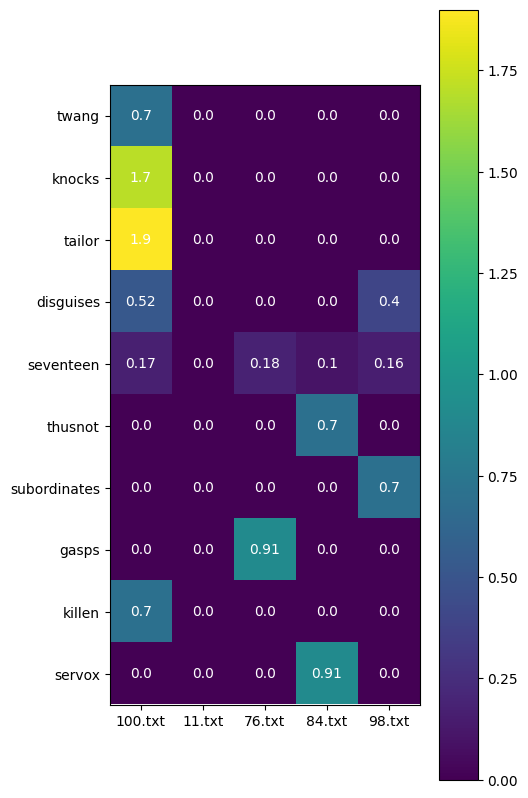

In [323]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np

y_labels = [(unique_terms[randint(0, num_terms)]) for i in range(10)]
x_labels = documents

viz = np.zeros((10,num_documents), dtype=float)


for i in range(len(y_labels)):
    viz[i] = tf_idf_weights[term_to_index[y_labels[i]]]

viz = np.round(viz, decimals=2)

#print(viz)

# Create the plot
plt.figure(figsize=(5, 10))
plt.imshow(viz, cmap='viridis', interpolation='nearest', aspect='auto')

# Add labels
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

# Annotate the matrix with the actual numbers
for i in range(viz.shape[0]):
    for j in range(viz.shape[1]):
        plt.text(j, i, f'{viz[i, j]}', ha='center', va='center', color='white')

# Add a color bar to represent the scale of the matrix values
plt.colorbar()

# Show the plot
plt.show()


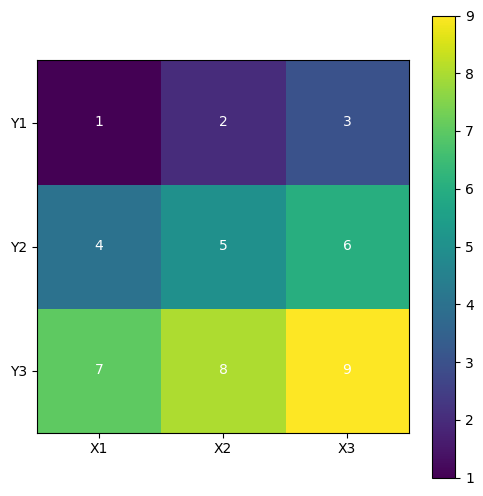

In [287]:
import matplotlib.pyplot as plt
import numpy as np

matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Labels for the matrix
x_labels = ['X1', 'X2', 'X3']
y_labels = ['Y1', 'Y2', 'Y3']

# Create the plot
plt.figure(figsize=(6, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')

# Add labels
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

# Annotate the matrix with the actual numbers
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, f'{matrix[i, j]}', ha='center', va='center', color='white')

# Add a color bar to represent the scale of the matrix values
plt.colorbar()

# Show the plot
plt.show()